In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from scipy.stats import poisson
import datetime as dt
from unidecode import unidecode
from glob import glob
from game_log import load_current_line
plt.rcParams['figure.figsize'] = [13, 7]
pd.set_option("display.precision", 3)
pd.set_option('display.max_columns', 37)

In [10]:
def get_all_game_logs():
    games = pd.DataFrame()
    for file in glob('game_logs/*'):
        df = pd.read_csv(file)
        games = pd.concat((games,df)).reset_index(drop=True)
    games['date'] = pd.to_datetime(games['date']).dt.tz_localize('US/Central').dt.floor('d')
    games = games.sort_values(by=['player','date'])
    return games

def get_all_pp():
    pp = pd.DataFrame()
    for file in (glob('Lines/old_nba/*') + glob('Lines/pp/*')):
        try:
            df = load_current_line(file,'scrape_time')
        except:
            df = pd.read_csv(file,index_col=0)
        pp = pd.concat((pp,df))
    pp = pp.reset_index(drop=True)
    pp = pp.sort_values(by='date')
    pp = pp.groupby(['date','player','stat']).last().reset_index()

    pp['date'] = pd.to_datetime(pp['date'],format='mixed',yearfirst=True,utc=True).dt.tz_convert('US/Central').dt.floor('d')
    return pp

games = get_all_game_logs()
pp = get_all_pp()

In [11]:
nba = pp.loc[pp.league_id == 7].reset_index()
comb = pp.merge(games,on=['player','date','opp'],how='inner')
print(len(comb))

In [15]:
def calc_outcome(row):
    outcome = 0
    for part in row['stat'].split('+'):
        try:
            outcome += row[part]
        except KeyError:
            return float('nan')
    return outcome

comb = pp.merge(games,on=['player','date','opp'])
comb['result'] = comb.apply(lambda row: calc_outcome(row),axis=1)
comb['o_u'] = ['under' if x > y else 'over' if x < y else 'push' for x, y in zip(comb['line'], comb['result'])]

In [17]:
display(comb['o_u'].value_counts())

o_u
under    12148
over     11574
push       546
Name: count, dtype: int64

In [20]:
display(comb.loc[comb.GS<0.5].groupby('stat')['o_u'].value_counts())

stat         o_u  
3P           over      33
             under     27
3PA          over       1
AST          under     32
             over      29
             push       2
BLK          over       7
             under      4
BLK+STL      over      23
             under      7
FGA          under      3
FT           over      71
             under     68
ORB          over       4
             under      3
PF           under      1
PTS          under    148
             over     126
             push       1
PTS+AST      under     94
             over      85
             push       1
PTS+TRB      under    135
             over     130
             push       1
PTS+TRB+AST  under     72
             over      47
STL          under     40
             over      29
TOV          over      25
             under     24
TRB          under     84
             over      78
             push      11
TRB+AST      over      29
             under     27
Name: count, dtype: int64

In [28]:
#potential edge:
#bench players go under all the time, mostly on pts
today = load_current_line('Lines\pp\pp_2023_12_5.csv','scrape_time','prop-id')
today = today.loc[today.league_id==7]

In [29]:
def round_to_bucket(value, bucket_size):
    if bucket_size < 1:
        return value
    else:
        return ((value + bucket_size - 1) // bucket_size) * bucket_size - bucket_size/2
round_to_bucket(5,3)

4.5

DRB
overall over %: 0.37398373983739835
num of bets: 131.0


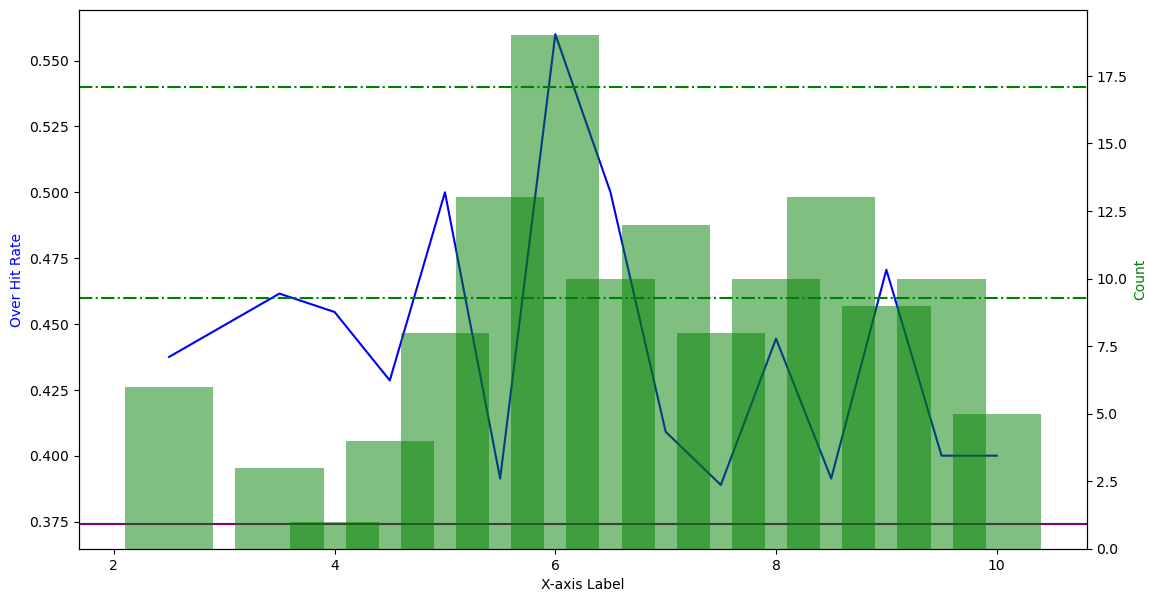

o_u,over,push,under,over_ratio,count
stat_hist,,,,,
2.5,2.0,0.0,4.0,0.438,6.0
3.5,1.0,0.0,2.0,0.462,3.0
4.0,0.0,0.0,1.0,0.455,1.0
4.5,1.0,0.0,3.0,0.429,4.0
5.0,4.0,0.0,4.0,0.500,8.0
5.5,4.0,0.0,9.0,0.391,13.0
6.0,9.0,4.0,6.0,0.560,19.0
6.5,5.0,0.0,5.0,0.500,10.0
7.0,4.0,0.0,8.0,0.409,12.0


In [30]:
def graph_history(df,stat,bucket):
    df['stat_hist'] = df['line'].apply(lambda x: round_to_bucket(x,bucket))
    print(stat)
    x = df.loc[df.stat == stat].groupby('stat_hist')['o_u'].value_counts().reset_index().copy(deep=True)
    pivot_df = x.pivot(index='stat_hist', columns='o_u', values='count').fillna(0)
    if 'push' in pivot_df.columns:
        pivot_df['push'].fillna(0,inplace=True)
    else:
        pivot_df['push'] = 0

    if 'over' in pivot_df.columns:
        pivot_df['over'].fillna(0,inplace=True)
    else:
        pivot_df['over'] = 0

    if 'under' in pivot_df.columns:
        pivot_df['under'].fillna(0,inplace=True)
    else:
        pivot_df['under'] = 0
    pivot_df['over_ratio'] =(pivot_df['over']+5)/ (10+pivot_df['under'] + pivot_df['over'])
    pivot_df['count'] = pivot_df['over'] + pivot_df['under'] + pivot_df['push']
    result_df = pivot_df.reset_index()
    over_percent = result_df['over'].sum() / (result_df['under'].sum() + result_df['over'].sum())
    print('overall over %:',over_percent)
    print(f"num of bets: {result_df['count'].sum()}")
    fig, ax1 = plt.subplots()
    ax1.plot(result_df['stat_hist'], result_df['over_ratio'], label='Over Ratio', color='blue')
    ax1.set_xlabel('X-axis Label')
    ax1.set_ylabel('Over Hit Rate', color='blue')

    # Create a second y-axis (right)
    ax2 = ax1.twinx()

    # Plotting the second set of data against the second y-axis (right)
    ax2.bar(result_df['stat_hist'], result_df['count'], label='Count', color='green', alpha=0.5)
    ax2.set_ylabel('Count', color='green')

    # Adding a horizontal line at y = 0.5
    ax1.axhline(y=0.46, color='green', linestyle='-.')
    ax1.axhline(y=0.54, color='green', linestyle='-.')
    ax1.axhline(y=over_percent, color='purple', linestyle='-')
    # Show plot
    plt.show()
    display(pivot_df)
    return

stat = 'DRB'
bucket = 0.5

graph_history(comb,stat,bucket)

In [33]:
x = comb.groupby(['player'])['o_u'].value_counts().reset_index()
piv = x.pivot(index=['player'], columns='o_u', values='count').fillna(0).reset_index()
piv['hit_rate'] = (piv['over'] + 20) /( piv['under'] + piv['over'] + 40)
piv = piv.loc[piv.over > 20]
piv = piv.sort_values(by=['hit_rate'])
piv.head(20)


o_u,player,over,push,under,hit_rate
113,Ja Morant,24.0,7.0,58.0,0.361
150,Jordan Poole,55.0,4.0,110.0,0.366
152,Josh Giddey,79.0,4.0,139.0,0.384
250,Russell Westbrook,55.0,6.0,99.0,0.387
241,RJ Barrett,45.0,4.0,83.0,0.387
133,Jarrett Allen,40.0,4.0,74.0,0.390
130,James Wiseman,27.0,0.0,51.0,0.398
181,Kyle Kuzma,66.0,2.0,109.0,0.400
58,Darius Garland,70.0,4.0,112.0,0.405
292,Zion Williamson,28.0,7.0,49.0,0.410


In [34]:
piv.loc[piv.player.isin(today.player)]

o_u,player,over,push,under,hit_rate
152,Josh Giddey,79.0,4.0,139.0,0.384
241,RJ Barrett,45.0,4.0,83.0,0.387
133,Jarrett Allen,40.0,4.0,74.0,0.390
58,Darius Garland,70.0,4.0,112.0,0.405
240,Quentin Grimes,28.0,0.0,49.0,0.410
...,...,...,...,...,...
284,Victor Wembanyama,38.0,0.0,24.0,0.569
38,Cameron Johnson,81.0,7.0,56.0,0.571
89,Eric Gordon,24.0,1.0,12.0,0.579
16,Austin Reaves,72.0,5.0,43.0,0.594


In [42]:
player = 'Jarrett Allen'
comb.loc[comb.player==player].groupby('stat')['o_u'].value_counts().reset_index()

,stat,o_u,count
0,BLK,under,1
1,BLK+STL,under,2
2,DRB,under,1
3,Dunks,push,1
4,FGA,under,1
5,FT,under,5
6,FT,over,1
7,ORB,over,1
8,PTS,under,11
9,PTS,over,3
